In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import seaborn as sns
from scipy.stats import norm, pearsonr, spearmanr, kendalltau
import scipy.stats as stats
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr
import cloudpickle as pickle

sns.set_context("paper")
simHei = FontProperties(fname=r'/usr/share/fonts/Chinses/simhei.ttf', size=10) 
import warnings
warnings.filterwarnings('ignore')

In [27]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc, recall_score, precision_score, average_precision_score, roc_auc_score, f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.impute import SimpleImputer, KNNImputer

In [6]:
RANDOM_SEED = 0

In [3]:
def scoring(clf, x, y):
    pred = clf.predict(x)
    proba = clf.predict_proba(x)[:, 1]
    TP = ((pred==1) & (y==1)).sum()
    FP = ((pred==1) & (y==0)).sum()
    TN = ((pred==0) & (y==0)).sum()
    FN = ((pred==0) & (y==1)).sum()
    sen = TP/ float(TP + FN)
    spe = TN / float(FP + TN)
    recall = recall_score(y, pred)
    precision = precision_score(y, pred)
    auc = roc_auc_score(y, proba)
    f1 = f1_score(y, pred)
    return [sen, spe, recall, precision, f1, auc]
            
def try_Models(X, Y):
    Method = {'Logistic(l1)':LogisticRegression(penalty='l1', random_state=RANDOM_SEED, solver='liblinear', class_weight='balanced'),
              'Logistic(l2)':LogisticRegression(penalty='l2', random_state=RANDOM_SEED, solver='liblinear', class_weight='balanced'),
              'DecisionTree':DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_SEED),
              'RandomForest':RandomForestClassifier(n_estimators=501, max_depth=5, class_weight='balanced', random_state=RANDOM_SEED),
              'GradientBoost':GradientBoostingClassifier(random_state=RANDOM_SEED),
              }
    results= []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED) # 随机分5-fold
    for method, clf in Method.items():
        self_scores = []
        cross_scores = []
        for train_index, test_index in skf.split(X, Y):
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            clf.fit(X_train, Y_train)
            self_scores.append(scoring(clf, X_train, Y_train))
            cross_scores.append(scoring(clf, X_test, Y_test))
        self_scores = list(pd.DataFrame(self_scores).mean())
        cross_scores = list(pd.DataFrame(cross_scores).mean())
        row = [method]
        row.extend(self_scores)
        row.extend(cross_scores)
        results.append(row)
    results = pd.DataFrame(results, columns=['classifier', 'self_sensitivity', 'self_specifity', 'self_recall',
                                             'self_precision', 'self_f1', 'self_auc', 'cross_sensitivity',
                                             'cross_specifity', 'cross_recall', 'cross_precision', 'cross_f1',
                                             'cross_auc',])
    return results

def plot_auc(X, Y, clf):
    plt.figure(1, (6, 5.5), dpi=300)
    k, tprs, aucs, mean_fpr = 0, [], [], np.linspace(0, 1, 100)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED) # 随机分5-fold
    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        clf.fit(X_train, Y_train)
        proba = clf.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(Y_test, proba)
        fpr, tpr, thresholds = roc_curve(Y_test, proba) # fpr,tpr 
        aucs.append(auc_score)
        k += 1
        tprs.append(np.interp(mean_fpr, fpr, tpr))#插值
        tprs[-1][0] = 0.0
        _ = plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC Fold %d(AUC = %0.2f)' %(k+1, auc_score)) # k-fold ROC
    _ = plt.plot([0, 1], [0, 1], ls='--', lw=2, color='r')
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    _ = plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    _ = plt.plot(mean_fpr, mean_tpr, color='b', 
                 label='Mean ROC(AUC=%0.2f $\pm$ %0.2f)'%(mean_auc, std_auc)) # k-fold mean ROC
    _ = plt.legend(loc='lower right')
    _ = plt.xlim([-0.05, 1.05])
    _ = plt.ylim([-0.05, 1.05])
    _ = plt.xlabel('False Positive Rate', fontsize=13)
    _ = plt.ylabel('True Positive Rate', fontsize=13)
    plt.show()

'Dietary patterns '

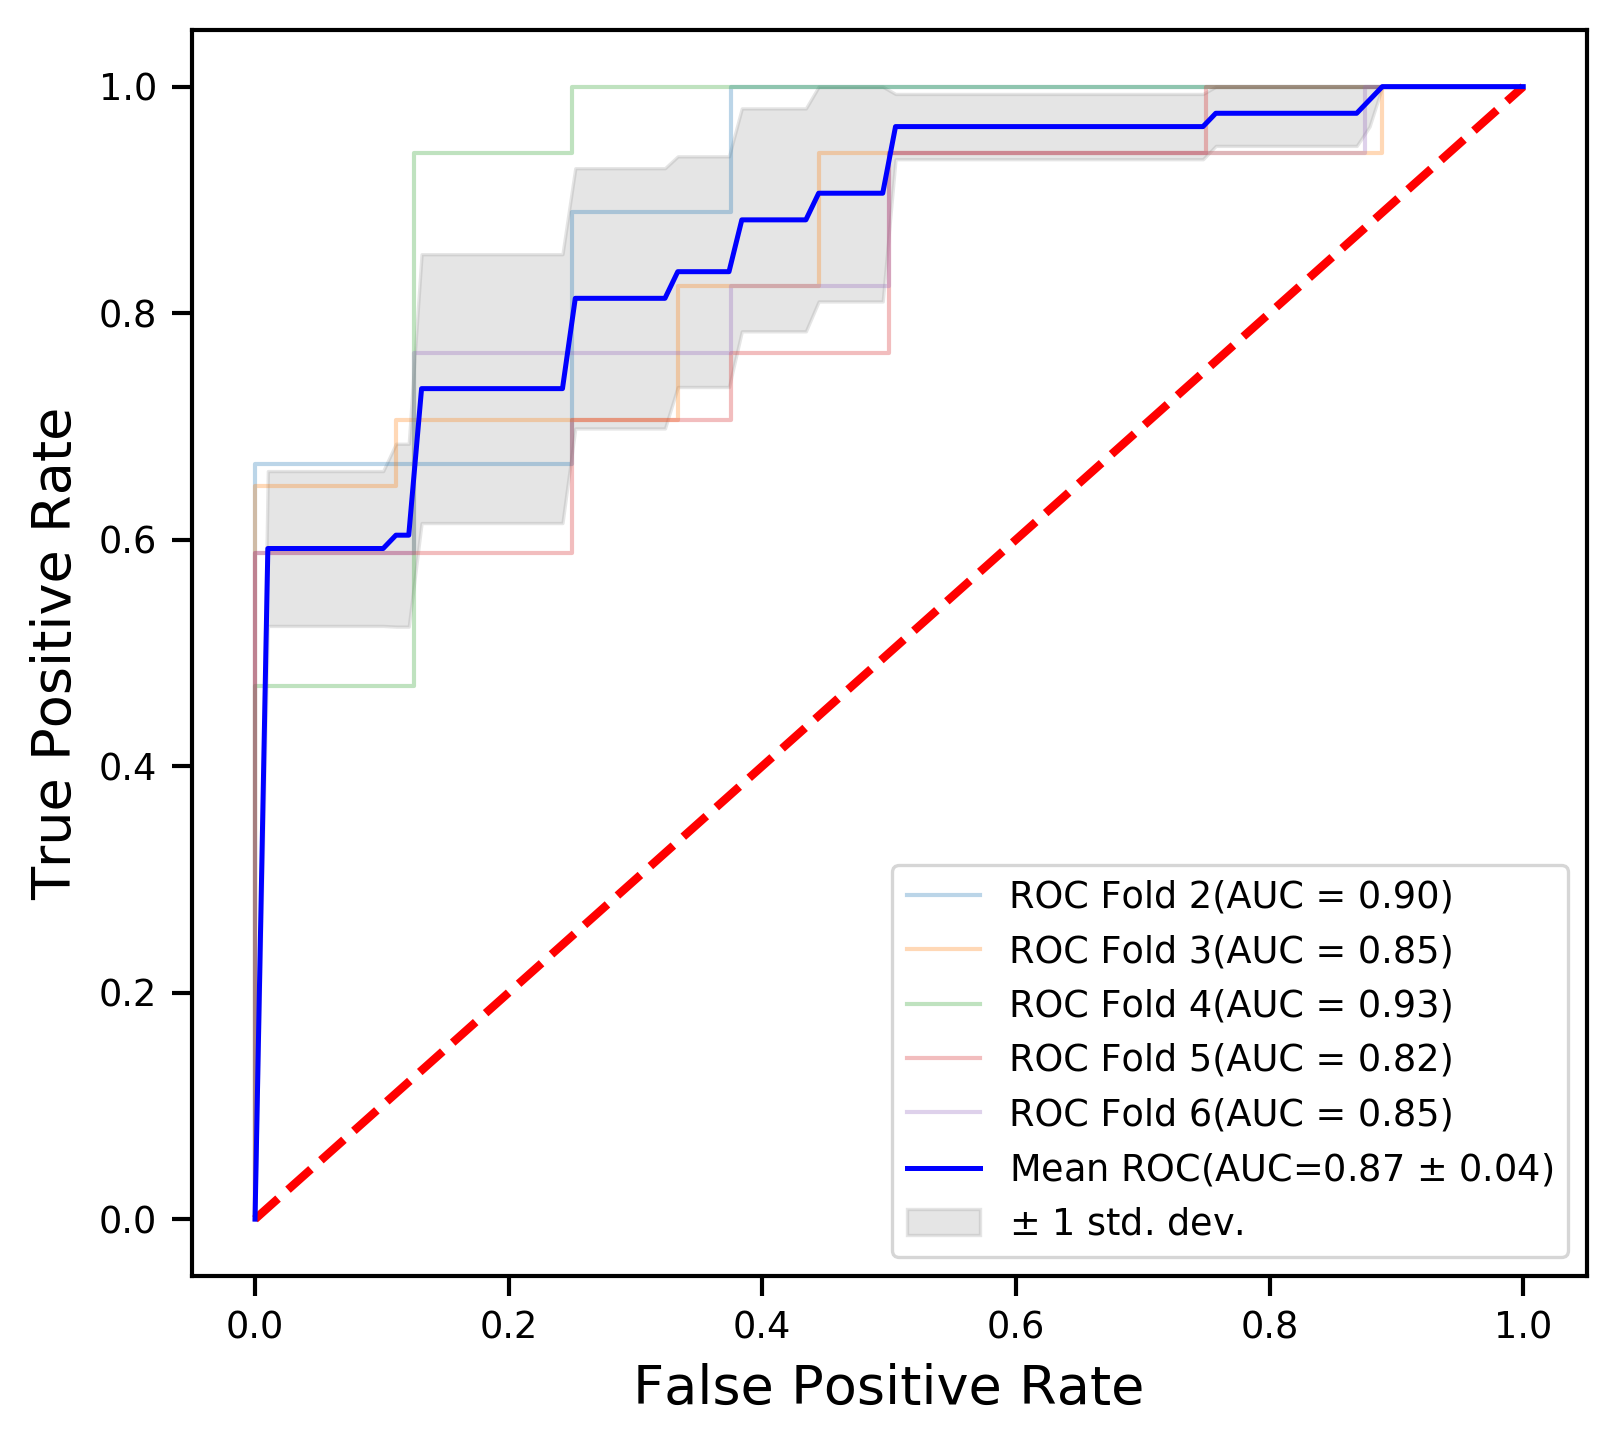

'Living environment'

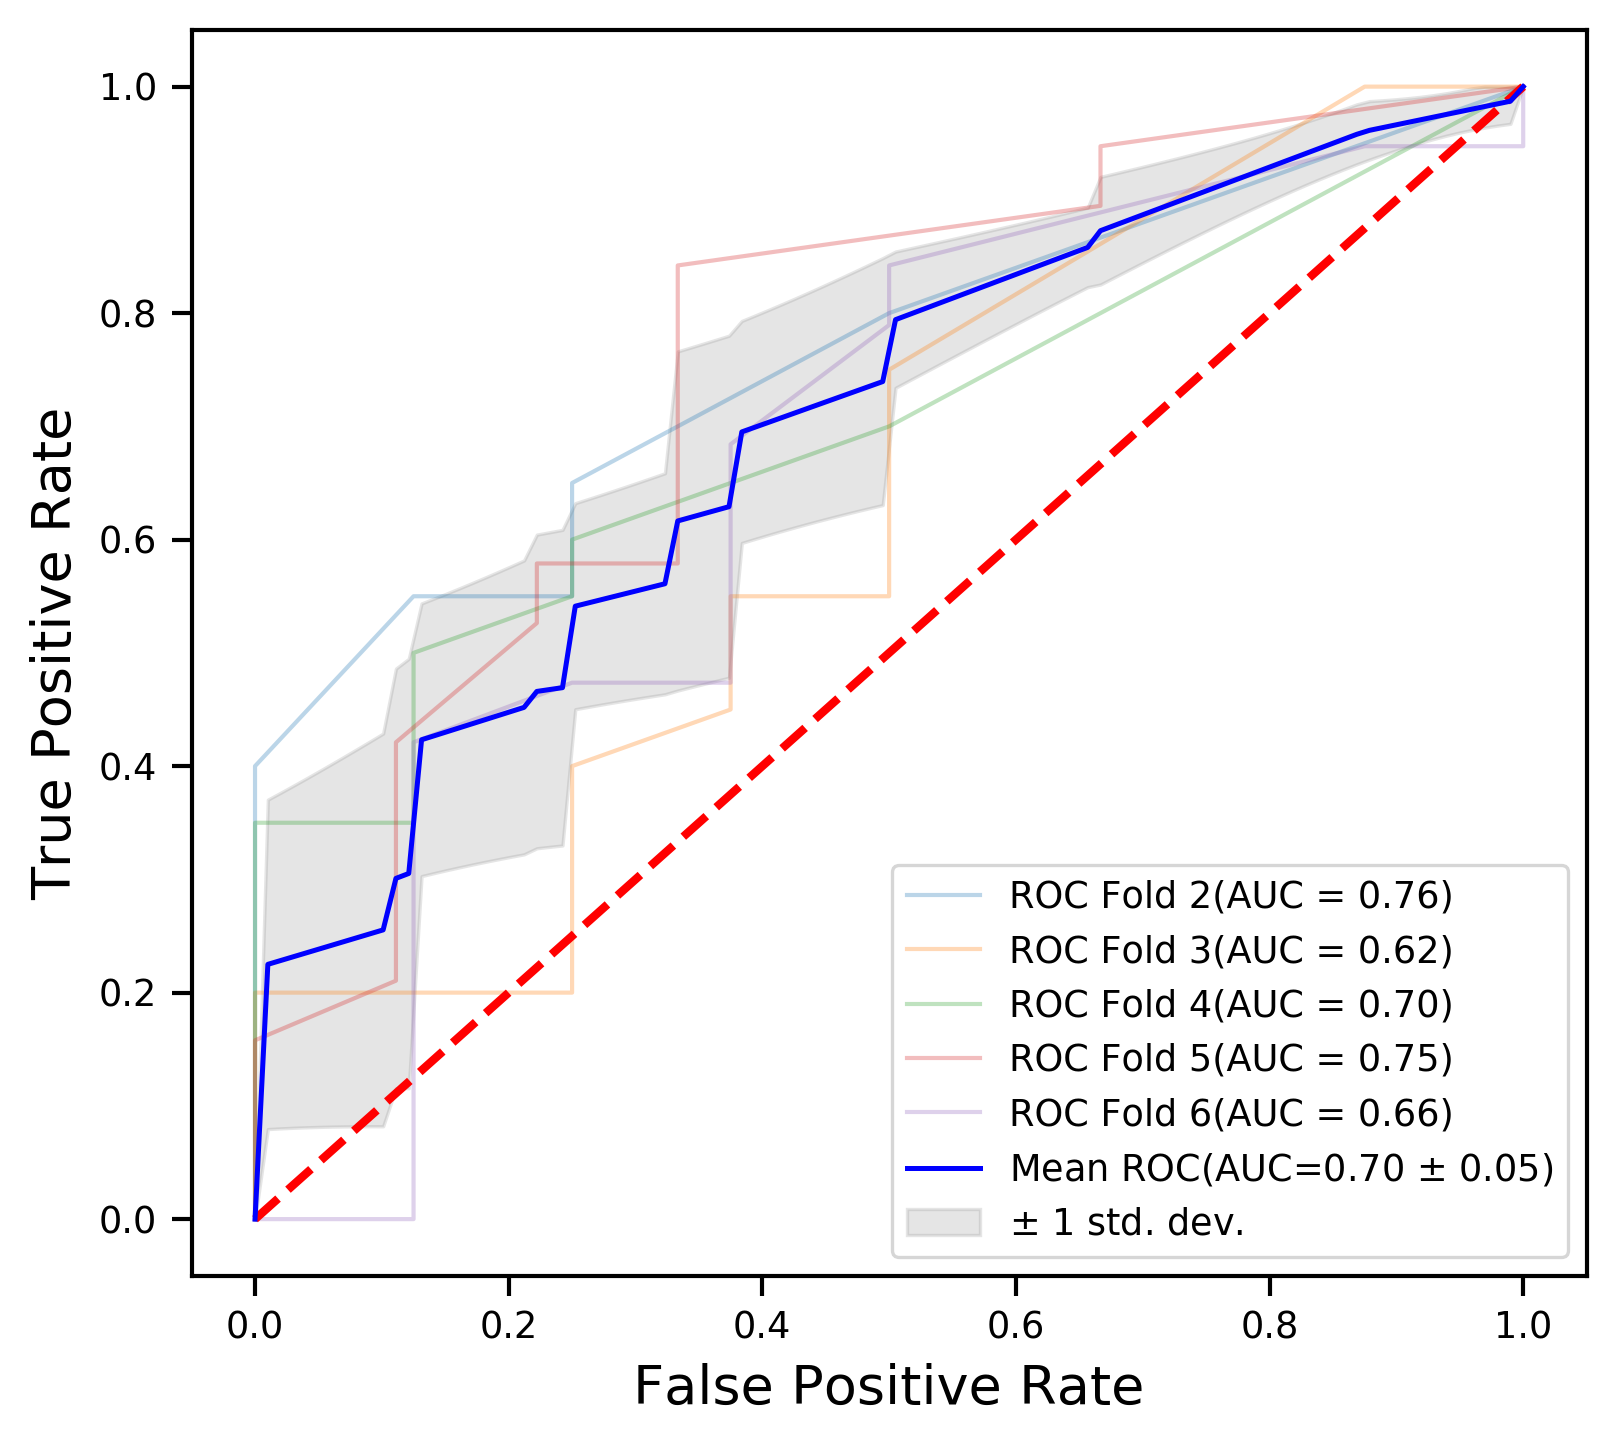

'maternal pregnancy and childbirth'

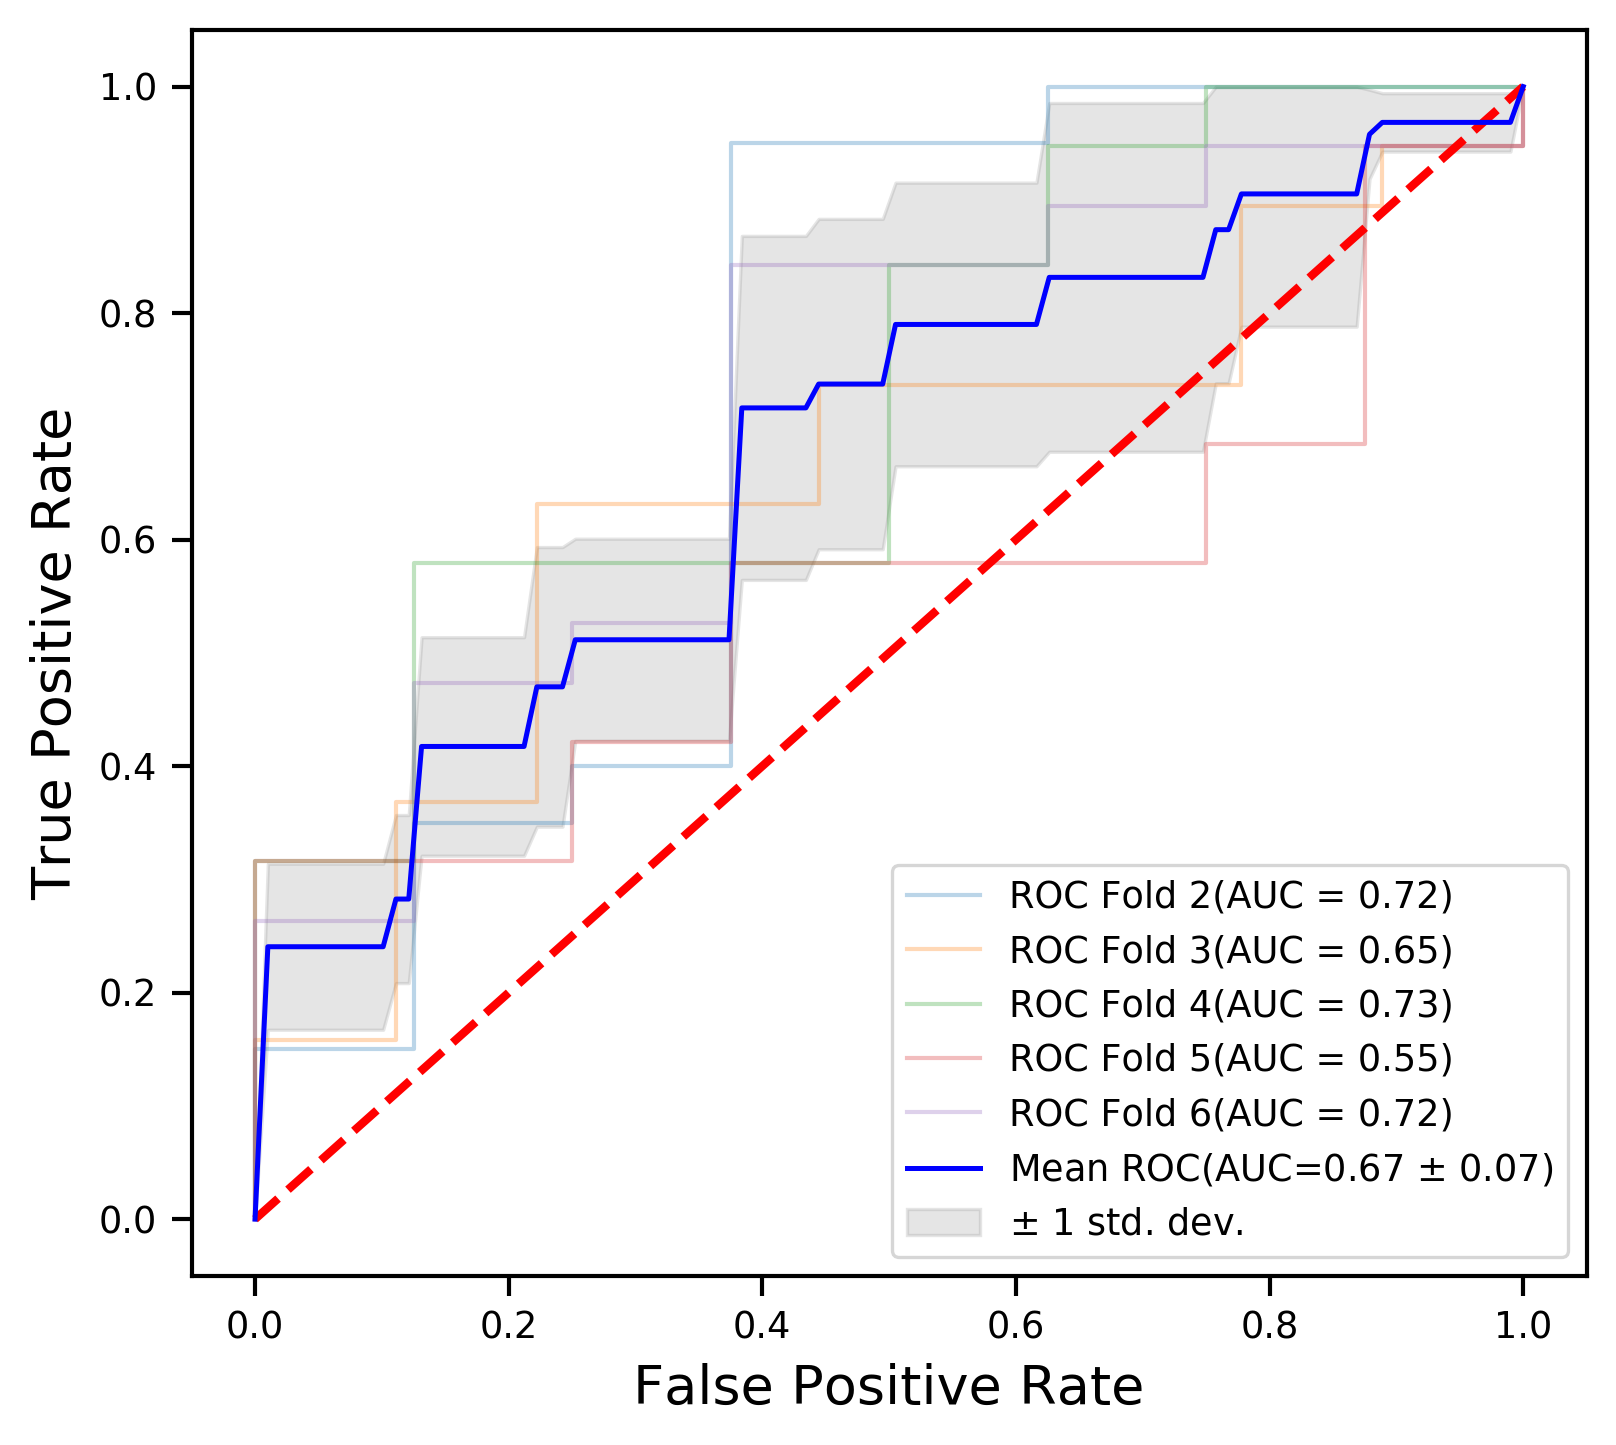

'physical condition'

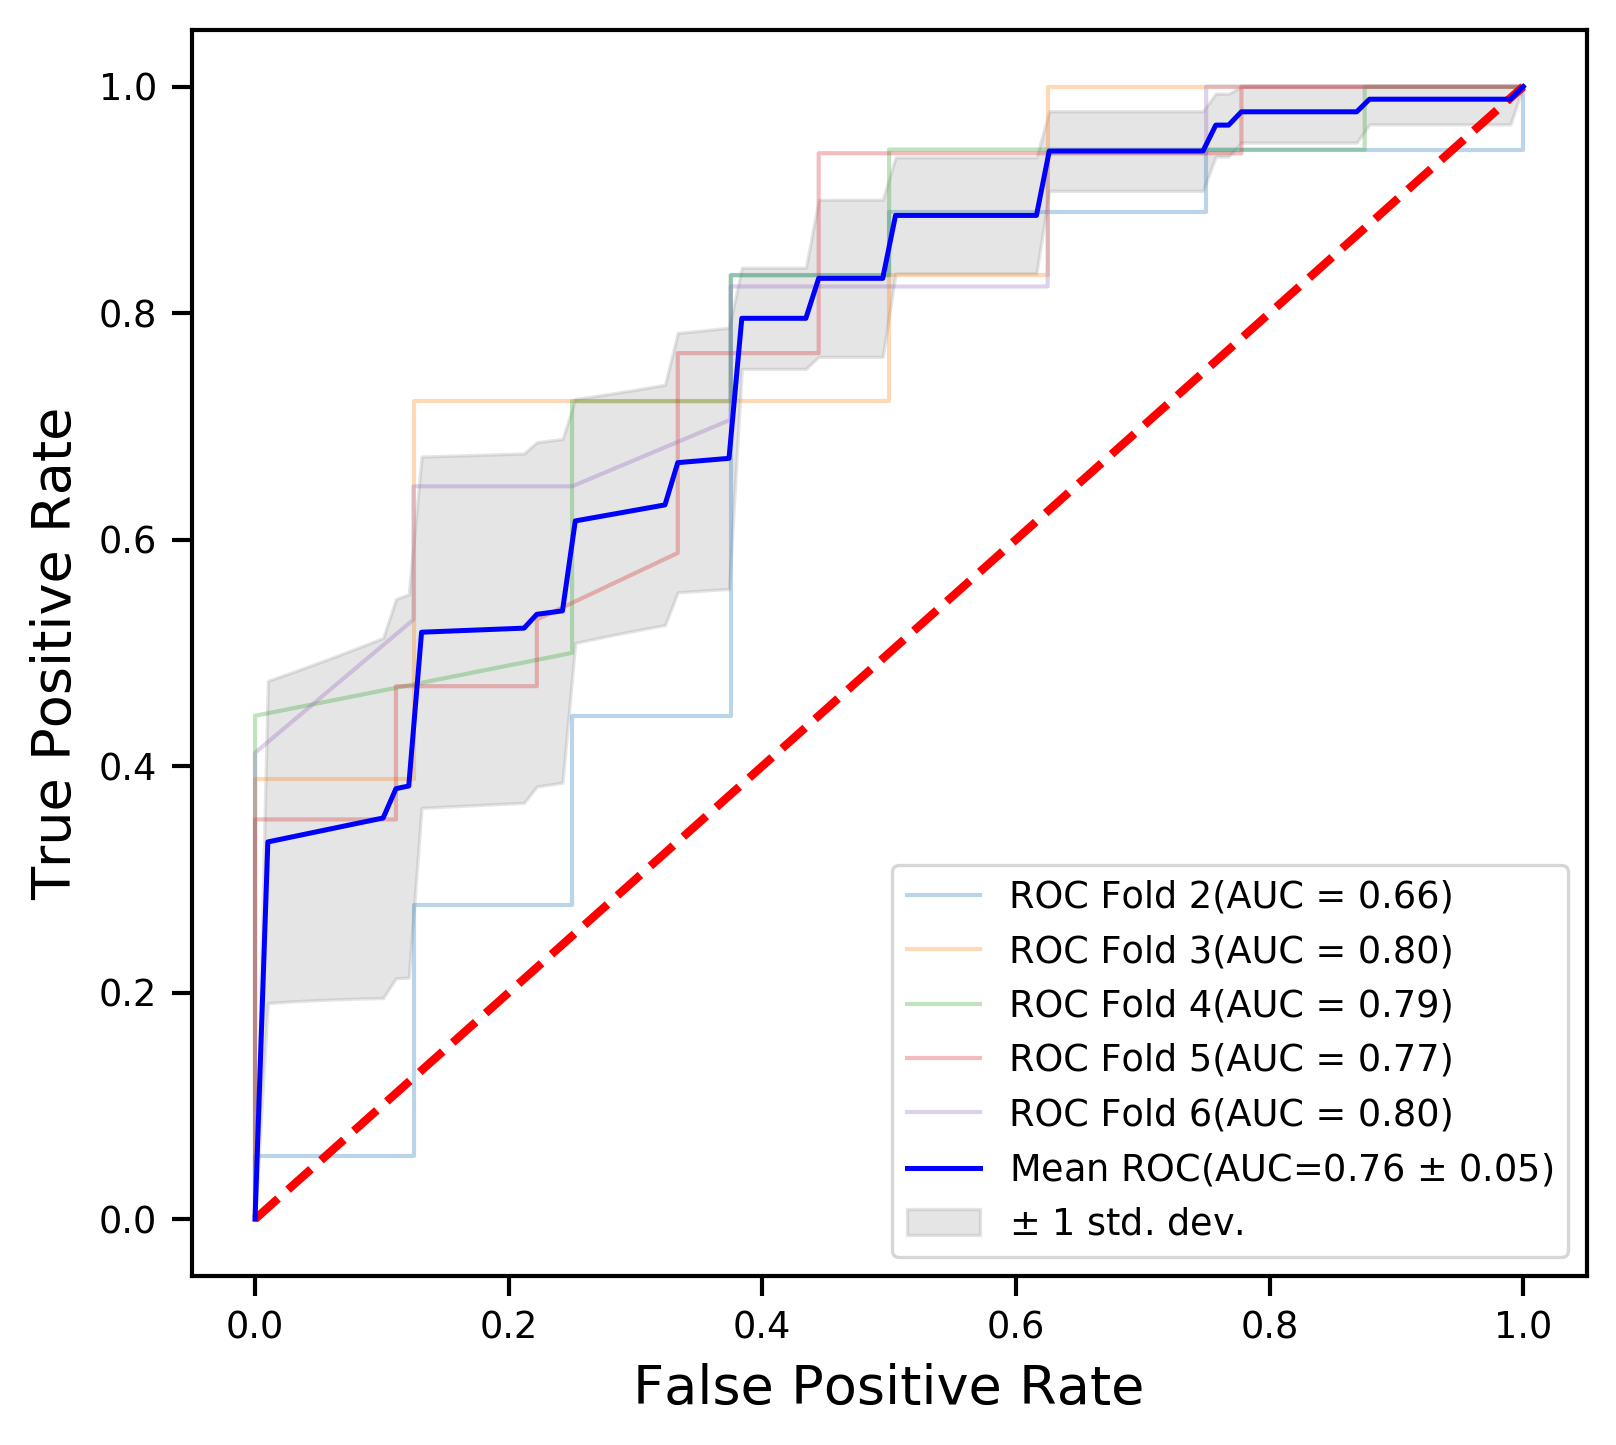

'physical condition of parents'

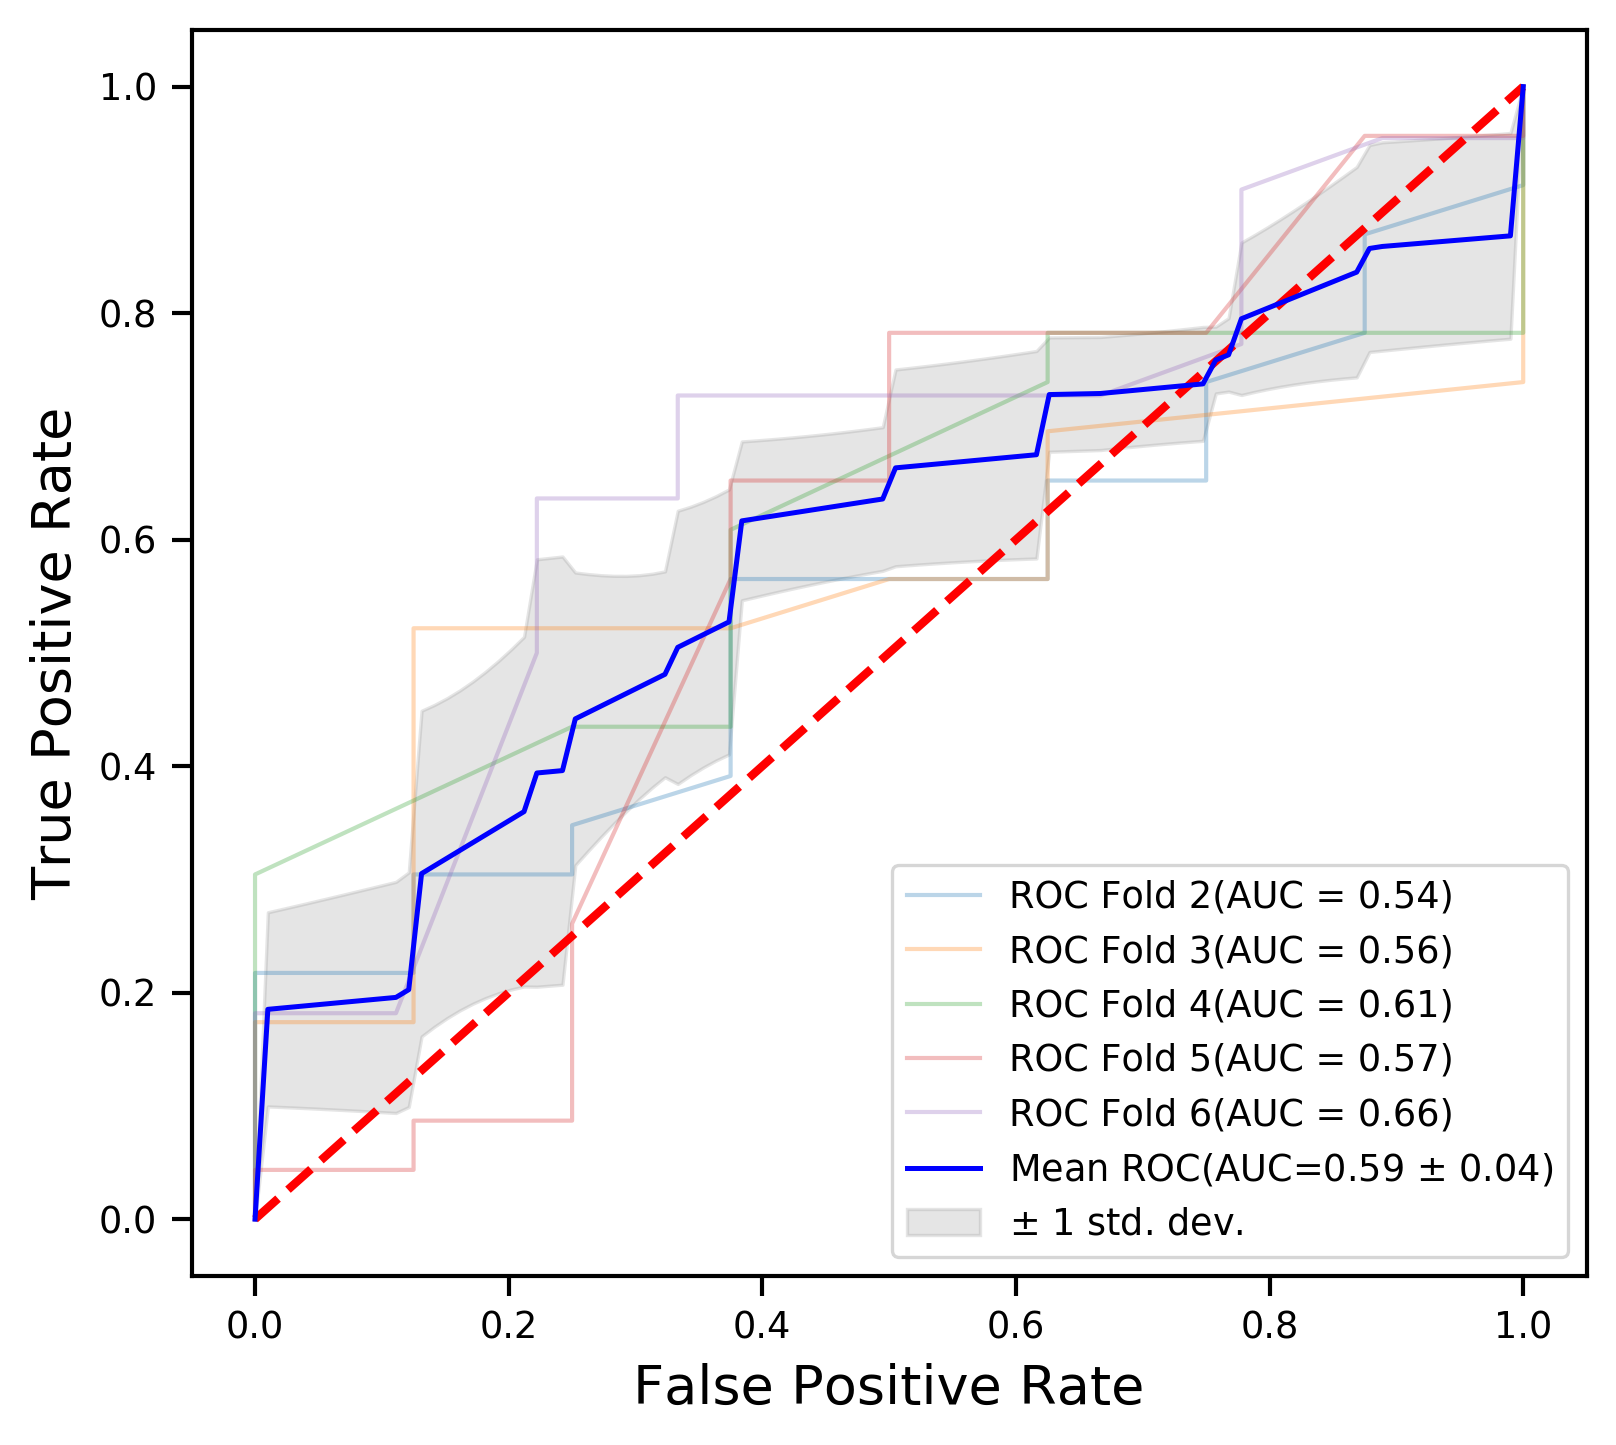

In [28]:
life_styles = [('Dietary patterns ', 'metadata_6_food.csv'),
               ('Living environment', 'metadata_5_env.csv'),
               ('maternal pregnancy and childbirth', 'metadata_3_childbirth.csv'),
               ('physical condition', 'metadata_4_illness.csv'),
               ('physical condition of parents', 'metadata_2_parents.csv')]

for l, file in life_styles:
    data = pd.read_csv('../data/Preprocess/'+file, index_col=0, sep=',')
    l
    X = data.values
    Y = np.array([0 if i[0]=='N' else 1 for i in data.index])
    imp = KNNImputer(n_neighbors=5)
    #imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    X = imp.fit_transform(X)
    clf = RandomForestClassifier(n_estimators=501, max_depth=5, class_weight='balanced', random_state=RANDOM_SEED)
    plot_auc(X, Y, clf)